TODO:


*   scaricato il dataset, si dovrebbe prendere test, train, val ed univerli "normal-penuomia", fare lo shuffle e creare le coppie immagini-label -> creare un'altra director "chest_ray_shuffled con "test, train, val". Come label si potrebbe semplicemente rinominare l'immagine come \<label\>\_\<test/train/val\>\<numeric_id\>. esempio normale_test_00001
*   eliminare il vecchio "chest_ray" directory che contiene le immagini non mischiate ( per motivi di memoria ). con `! rm -rf /content/chest_ray`
*   vedere come utilizzare la kan ( da error )
*   provare a creare l'oggetto dataset "ChestRay_DataModule"
*   provare a creare l'oggetto architettura "JAM"
*   vedere se una immagine ed un batch viene parsata dalla rete
*   scegliere una colormap per la [heatmap](https://www.shutterstock.com/image-vector/heat-map-abstract-infrared-thermographic-260nw-2239656403.jpg) , ce ne sono varie, alcune fanno "peggio" ed altre vanno bene. Oppure scegliere un preprocessing in generale






# Init

## Installation

In [ ]:
%%capture
!pip install gdown tqdm
!pip install hydra-core
!pip install pytorch_lightning torchvision wget --quiet
#!pip install kan

## Import and preparation

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader,  Dataset

import pytorch_lightning as pl

#from kan import KAN

import cv2
from PIL import Image
import matplotlib.pyplot as plt
#import hydra
#from omegaconf import DictConfig, OmegaConf

import os
import wget
import gdown
import zipfile
from tqdm.notebook import tqdm
from google.colab import drive

Global variables where I store hyperparamters read from yaml file

In [ ]:
global_var = {
    # Dataset download
    'link_download_prefix' : 'https://drive.google.com/uc?export=download&id=YOUR_FILE_ID',
    "link_dataset": "https://drive.google.com/file/d/10un_W7teXQy9LOB1uqd0e6VJ46UFNRza/view?usp=drive_link0",
    "path_download_dataset": "/content/dataset.zip",
    "extract_directory": "/content",
    "dataset_name": "chest_xray",

    # Train
    'batch_size': 32,
    'hidden_dim': 8,
    'epochs': 10

    # hyperparamter search
}

In [ ]:
class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [ ]:
# Set randomness always the same at each run
pl.seed_everything(0)

INFO:lightning_fabric.utilities.seed:Seed set to 0


0

# Utils

In [ ]:
def download_dataset(link_dataset, delete_zip_file=False):

    """
    Given the link of the dataset in google drive, download it.

    Args:
        link_dataset = link to zip files
        delete_zip_file = {True/False}, use to remove the zip file once extracted the content

    Note: the link my be public or gdown can't download it
    """


    # Creating string for download

    link_download_base =  global_var['link_download_prefix']

    id_dataset = link_dataset.split("/view")[0].split("/")[-1]

    dataset_download_link = link_download_base.replace("YOUR_FILE_ID", id_dataset)

    path_download_dataset = global_var['path_download_dataset']

    dataset_name = global_var['dataset_name']

    extract_directory = global_var['extract_directory']

    # Downloading zip file
    try:
        if not( os.path.exists(path_download_dataset) ):
            gdown.download(
                url=dataset_download_link,
                output=path_download_dataset,
                quiet=False
            )
            print(f"{Color.GREEN}\nZip file downloaded{Color.RESET}")
        else:
            print(f"{Color.GREEN}Zip file already downloaded{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Download went wrong!\nerror:{Color.RESET}")
        print(error)


    # Unzipping the file
    try:
        if not( os.path.exists(dataset_name) ):

            with zipfile.ZipFile(path_download_dataset, 'r') as zip_file:

                n_files = len(zip_file.namelist())

                with tqdm(total=n_files, desc='Unzipping files') as pbar:
                    for file_name in zip_file.namelist():
                        zip_file.extract(member=file_name, path=extract_directory)
                        pbar.update(1)

            #! unzip -q {name_dataset}
            print(f"{Color.GREEN}File {dataset_name} unziped{Color.RESET}")
        else:
            print(f"{Color.GREEN}File {dataset_name} already unziped{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Unzip went wrong!\nerror:{Color.RESET}")
        print(error)

    # removing zip file
    try:
        if delete_zip_file == True:
            ! rm {path_download_dataset}
            print(f"{Color.GREEN}File {path_download_dataset} removed{Color.RESET}")
    except Exception as error:
        print(f"{Color.RED}Could not remove zip file, pass!\nerror:{Color.RESET}")
        print(error)
        pass

In [ ]:
def merge_dataset(dataset_directory):

    

    return

In [ ]:
def setup_device():

    """
    Setup device to be used
    """

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print(f"Current device: {device}")

In [ ]:
def get_heatmap(img_path):
    """
    Given the path for an image, extract a colormap to highlight details

    Args:
        img_path: path to the image

    Note: Colormap documentation, https://docs.opencv.org/3.4/d3/d50/group__imgproc__colormap.html

    """

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img_colored = cv2.applyColorMap(img_normalized, cv2.COLORMAP_TWILIGHT)
    img_rgb = cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB)

    return img_rgb

# Dataset information

Fare plot dataset etc, ...

# Dataset Module

Rference https://lightning.ai/docs/pytorch/stable/data/datamodule.html

Queste cose sono solo abbozzate, copia ed incolla dal sito e riscritte

In [ ]:
class ChestRay_Dataset(Dataset):

    def __init__(self,file_path,mv_flag):
        self.file_path = file_path
        #self.transform_mv = transforms.Compose([embed_data])

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, index):
        sample = self.sample_names[index]
        label = 0

        return sample,label

In [ ]:
class ChestRay_DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        #self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    def prepare_data(self):
        # download dataset -> not needed
        return

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
           chest_ray_train = None

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.chest_ray_test = None #MNIST(self.data_dir, train=False, transform=self.transform)

        if stage == "predict":
            self.chest_ray_predict =None #MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.chest_ray_train, batch_size=32)

    def val_dataloader(self):
        return DataLoader(self.chest_ray_val, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.chest_ray_test, batch_size=32)

    def predict_dataloader(self):
        return DataLoader(self.chest_ray_test, batch_size=32) # Test?

# Architecture

Reference: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

Queste cose sono solo abbozzate, copia ed incolla dal sito e riscritte

In [ ]:
class JAM_network(pl.LightningModule):
    def __init__(self, input_dim):
        super(JAM_network,self).__init__()

        # insert layer, etc ...

    def forward(network_input):
        return network_input

In [ ]:
class JAM(pl.LightningModule):
    def __init__(self, vocab_size):
        super(JAM).__init__()
        self.model = JAM_network(0)

        # insert metric, fnc_loss


    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs, target)
        loss = torch.nn.functional.nll_loss(output, target.view(-1))
        return loss

    def validation_step(self, batch):
        loss = 0
        return loss

    def test_step(self, batch):
        loss = 0
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

# Main

In [ ]:
print(f"{Color.GREEN}prova{Color.RESET}")

prova


In [ ]:
download_dataset(
     link_dataset=global_var['link_dataset'],
     delete_zip_file=False
 )

Zip file already downloaded 
File chest_xray already unziped 


In [ ]:
setup_device()

Current device: cpu


(-0.5, 1856.5, 1316.5, -0.5)

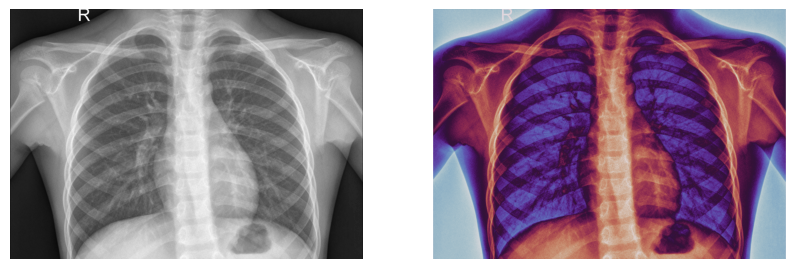

In [ ]:
normal_img_path = "chest_xray/test/NORMAL/IM-0001-0001.jpeg"
normal_img = Image.open(normal_img_path)
normal_img = np.array(normal_img)
processed_img = get_heatmap(normal_img_path) # Ci sono altri tipi ti filtri per fare l'highlight ( fatto per bene ), ne ho scelto uno

plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normal_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed_img)
plt.axis('off')

(-0.5, 1105.5, 761.5, -0.5)

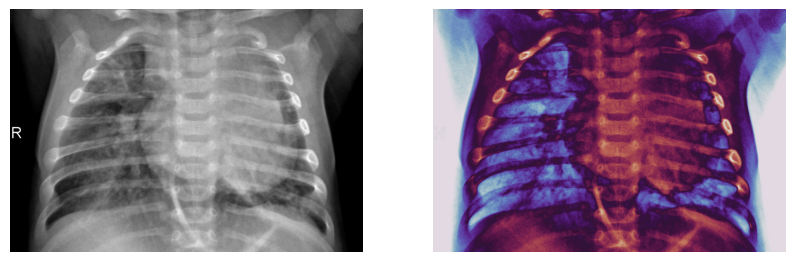

In [ ]:
normal_img_path = "chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
normal_img = Image.open(normal_img_path)
normal_img = np.array(normal_img)
processed_img = get_heatmap(normal_img_path)

plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normal_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed_img)
plt.axis('off')